In [1]:
import requests
import pandas as pd
import time

def get_repos(username, token):
    """Fetches all repositories of a given GitHub user."""
    repos = []
    page = 1
    while True:
        url = f"https://api.github.com/users/{username}/repos?page={page}&per_page=100"
        headers = {'Authorization': f'token {token}'}
        response = requests.get(url, headers=headers)
        if response.status_code != 200:
            raise Exception(f"Error fetching repositories: {response.status_code}")
        page_repos = response.json()
        if not page_repos:
            break
        repos.extend(page_repos)
        page += 1
    return repos

def get_commits_for_repos(username, repos, token):
    """Fetches commit data for each repository and accumulates commit counts."""
    all_commits_data = []
    repo_checkins = {}  # Track first check-in date for each repo
    repo_commits_cumulative = {}  # Track cumulative commits for each repo

    for repo in repos:
        repo_name = repo['name']
        print(f"Fetching commits for repository: {repo_name}")

        commits_url = f"https://api.github.com/repos/{username}/{repo_name}/commits"
        page = 1
        while True:
            headers = {'Authorization': f'token {token}'}
            response = requests.get(commits_url, params={'per_page': 100, 'page': page}, headers=headers)
            if response.status_code != 200:
                print(f"Error fetching commits for {repo_name}, page {page}: {response.status_code}")
                break
            response_data = response.json()
            if len(response_data) == 0:
                break

            for commit in response_data:
                try:
                    commit_date = commit['commit']['author']['date'][:10]  # YYYY-MM-DD
                    all_commits_data.append({'date': commit_date, 'repo': repo_name})
                except KeyError:
                    print(f"Error processing commit data for {repo_name}, commit: {commit}")

            page += 1

    return all_commits_data

def main():
    # Set up the GitHub username and token
    username = "ursa-mikail"
    token = "YOUR_TOKEN_HERE"  # Replace with your GitHub token (ciphered: U2FsdGVkX1+7TtLL8EZXcO+sDvRQ830mnmRH+1bPozCC3DDFIc4hyk/kAlvk6OBrlMhC6s/DVrAJypjnA/6zdQ==)

    # Fetch repositories
    repos = get_repos(username, token)

    # Fetch commits for all repositories
    commits_data = get_commits_for_repos(username, repos, token)

    # Convert commit data into DataFrame
    df = pd.DataFrame(commits_data)

    # Clean up repository names (remove extra spaces and lowercase)
    df['repo'] = df['repo'].str.strip().str.lower()

    # Sort by date and remove duplicates for unique repo-counting
    df = df.sort_values(by=['repo', 'date'])
    df = df.drop_duplicates(subset=['repo', 'date'])

    # Initialize variables for cumulative counts
    repo_checkins = {}
    repo_cumulative = []
    repo_commits_cumulative = {}

    # Loop through the commits and accumulate
    cumulative_repos = 0
    for idx, row in df.iterrows():
        repo = row['repo']
        if repo not in repo_checkins:
            # First check-in for the repository
            repo_checkins[repo] = row['date']
            cumulative_repos += 1  # Increment cumulative repo count

        # Accumulate commit count for this repository
        if repo not in repo_commits_cumulative:
            repo_commits_cumulative[repo] = 0
        repo_commits_cumulative[repo] += 1

        # Add cumulative commit count to the row
        row['cumulative_commits'] = repo_commits_cumulative[repo]
        repo_cumulative.append(cumulative_repos)

    df['cumulative_repos'] = repo_cumulative  # Add cumulative repo column

    # Save the results to a CSV file
    file_git_commits_csv = './sample_data/git_commits.csv'
    df.to_csv(file_git_commits_csv, index=False)

    print("CSV file 'git_commits.csv' created successfully.")

# Run the main function
if __name__ == "__main__":
    main()


Fetching commits for repository: about_primes
Fetching commits for repository: activity_monitoring
Fetching commits for repository: aes_utility
Fetching commits for repository: ambassador_pattern_example
Fetching commits for repository: app_site_demo
Fetching commits for repository: At-The-Back-Of-Your-Head-An-Insight-To-Mnemonics
Fetching commits for repository: banking_transaction_and_in_memory_database_system
Fetching commits for repository: basic_openai_api_usage
Fetching commits for repository: batch_text_replacement
Fetching commits for repository: beginning_ML_analytics
Fetching commits for repository: binary_field_multiplication
Fetching commits for repository: birthday_paradox
Fetching commits for repository: blockchain_simple_learn_demo
Fetching commits for repository: bolting_and_molting_with_golang_an_anarchist_coding_cook_book
Fetching commits for repository: bolting_and_molting_with_rust_an_anarchist_coding_cook_book
Fetching commits for repository: cache_friendly_b_tree_

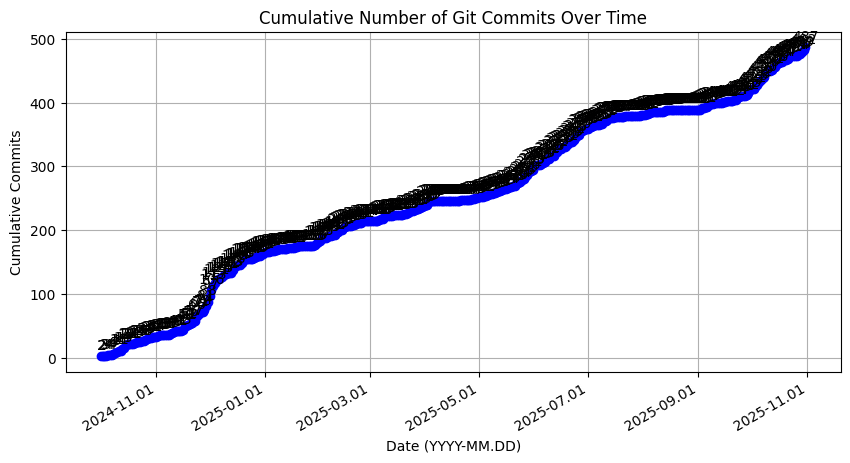

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_git_commits_csv = './sample_data/git_commits.csv'  # Path to your CSV file
df = pd.read_csv(file_git_commits_csv)

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Group by date and count the number of commits (assuming 'repo' column exists)
df_grouped = df.groupby('date').size().reset_index(name='commits')

# Create a date range from the start to the end date in the data
date_range = pd.date_range(start=df_grouped['date'].min(), end=df_grouped['date'].max())

# Reindex the DataFrame to include all dates in the range and fill missing dates with 0 commits
df_grouped = df_grouped.set_index('date').reindex(date_range, fill_value=0).rename_axis('date').reset_index()

# Calculate cumulative commits for annotation
df_grouped['cumulative_commits'] = df_grouped['commits'].cumsum()

# Plot 1: Cumulative Commits Over Time
plt.figure(figsize=(10, 5))
plt.plot(df_grouped['date'], df_grouped['cumulative_commits'], marker='o', linestyle='-', color='b')
plt.xlabel('Date (YYYY-MM.DD)')
plt.ylabel('Cumulative Commits')
plt.title('Cumulative Number of Git Commits Over Time')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m.%d'))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

# Annotate the points with the cumulative number of commits
for i, row in df_grouped.iterrows():
    plt.annotate(row['cumulative_commits'], (row['date'], row['cumulative_commits']),
                 textcoords="offset points", xytext=(0,5), ha='center')

# Show the first plot
plt.show()


Total unique repositories: 150


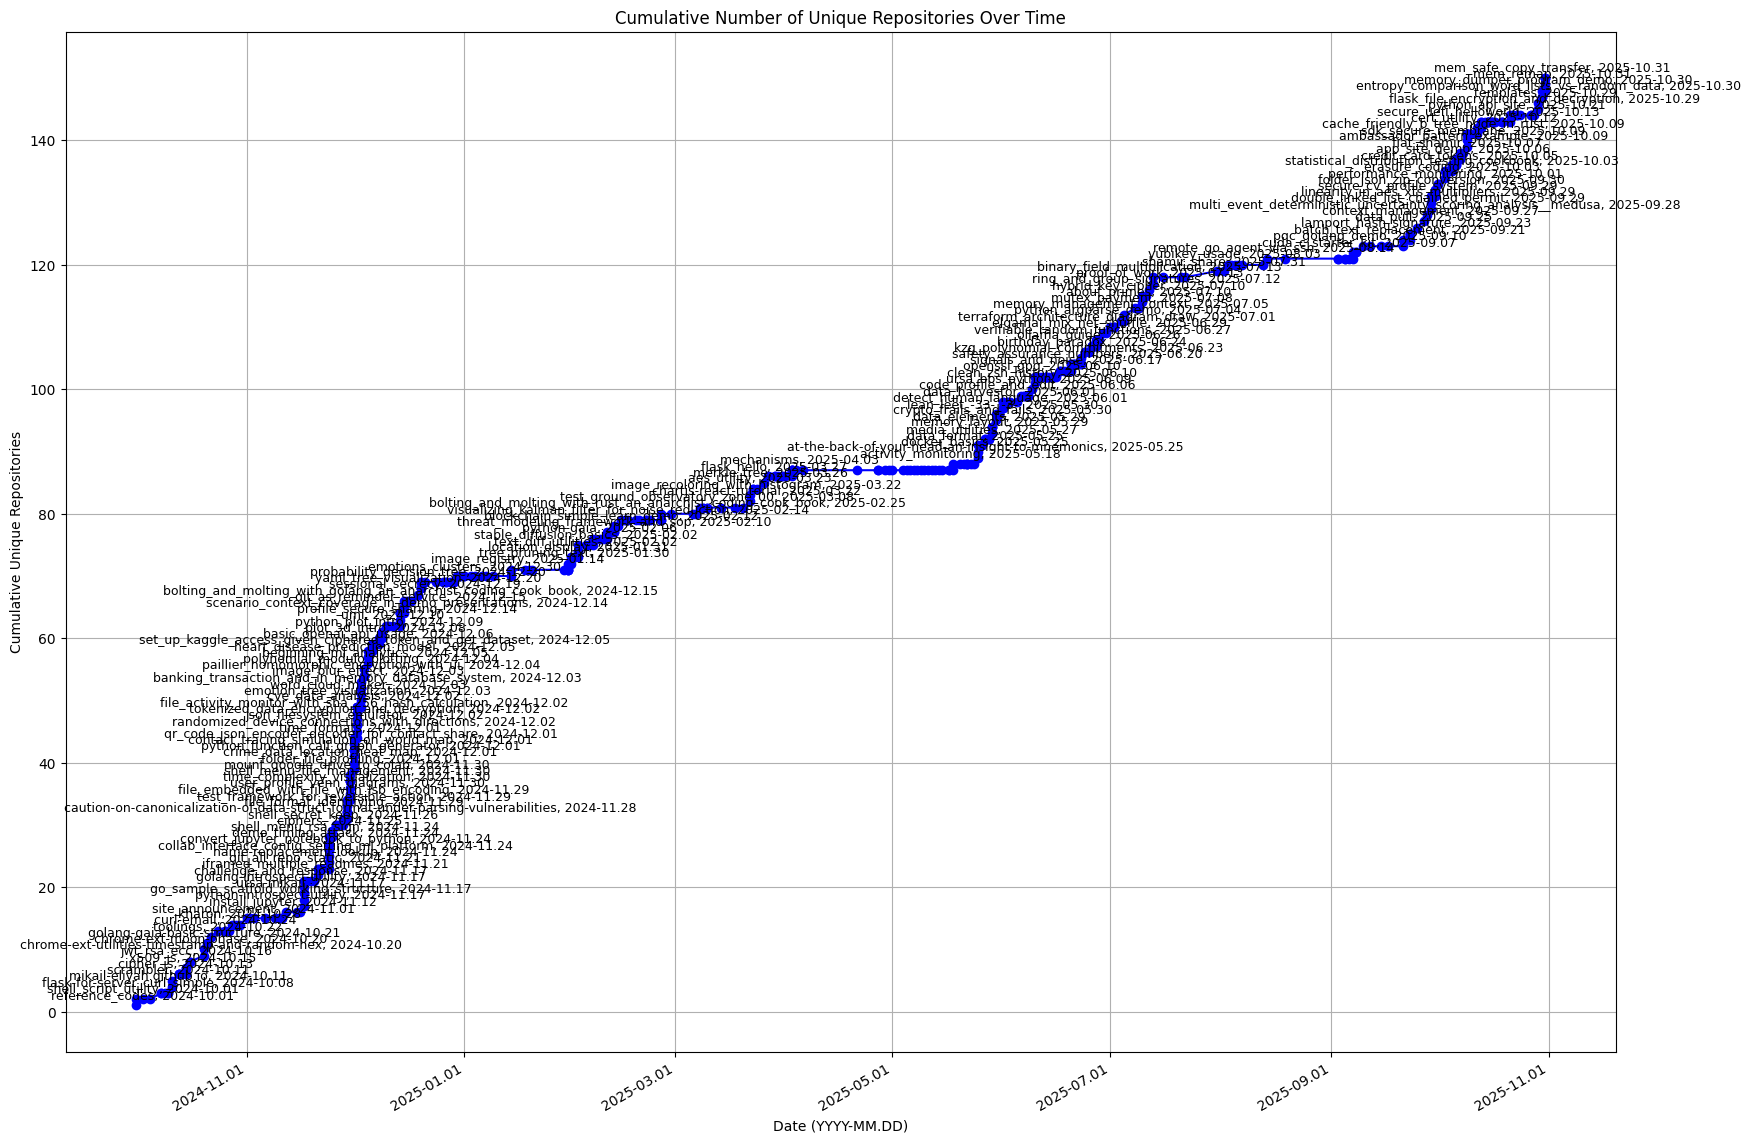

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv(file_git_commits_csv)

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Clean repository names (standardize case and remove extra spaces)
df['repo'] = df['repo'].str.strip().str.lower()

# Sort by date to ensure that repos are processed in the correct order
df = df.sort_values(by='date')

# Remove duplicates to avoid counting the same repository on the same date
df = df.drop_duplicates(subset=['repo', 'date'])

# Keep track of unique repositories and their first check-in dates
repo_checkins = {}  # Dictionary to store the first check-in date for each repo

# List to accumulate the cumulative repo counts
repo_cumulative = []

# Loop through the dataframe and calculate the cumulative unique repo count
cumulative_repos = 0
for idx, row in df.iterrows():
    repo = row['repo']
    if repo not in repo_checkins:
        # First check-in for this repo
        repo_checkins[repo] = row['date']
        cumulative_repos += 1  # Increment the cumulative repo count
    repo_cumulative.append(cumulative_repos)

# Add the cumulative repo count to the dataframe
df['cumulative_repos'] = repo_cumulative

# Print the number of unique repositories to check the count
print(f"Total unique repositories: {df['repo'].nunique()}")

# Plot: Cumulative Unique Repositories Over Time
plt.figure(figsize=(20, 15))
plt.plot(df['date'], df['cumulative_repos'], marker='o', linestyle='-', color='b')
plt.xlabel('Date (YYYY-MM.DD)')
plt.ylabel('Cumulative Unique Repositories')
plt.title('Cumulative Number of Unique Repositories Over Time')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m.%d'))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

# Annotate the points with the first appearance of each repo
for idx, row in df.iterrows():
    if row['repo'] in repo_checkins and row['date'] == repo_checkins[row['repo']]:
        plt.annotate(f"{row['repo']}, {row['date'].strftime('%Y-%m.%d')}",
                     (row['date'], row['cumulative_repos']),
                     textcoords="offset points", xytext=(5, 5), ha='center', fontsize=9)

# Show the plot
plt.show()


Fetching repositories...
Found 150 repositories
Fetching commits...
Fetching commits for repository: about_primes
Fetching commits for repository: activity_monitoring
Fetching commits for repository: aes_utility
Fetching commits for repository: ambassador_pattern_example
Fetching commits for repository: app_site_demo
Fetching commits for repository: At-The-Back-Of-Your-Head-An-Insight-To-Mnemonics
Fetching commits for repository: banking_transaction_and_in_memory_database_system
Fetching commits for repository: basic_openai_api_usage
Fetching commits for repository: batch_text_replacement
Fetching commits for repository: beginning_ML_analytics
Fetching commits for repository: binary_field_multiplication
Fetching commits for repository: birthday_paradox
Fetching commits for repository: blockchain_simple_learn_demo
Fetching commits for repository: bolting_and_molting_with_golang_an_anarchist_coding_cook_book
Fetching commits for repository: bolting_and_molting_with_rust_an_anarchist_codi

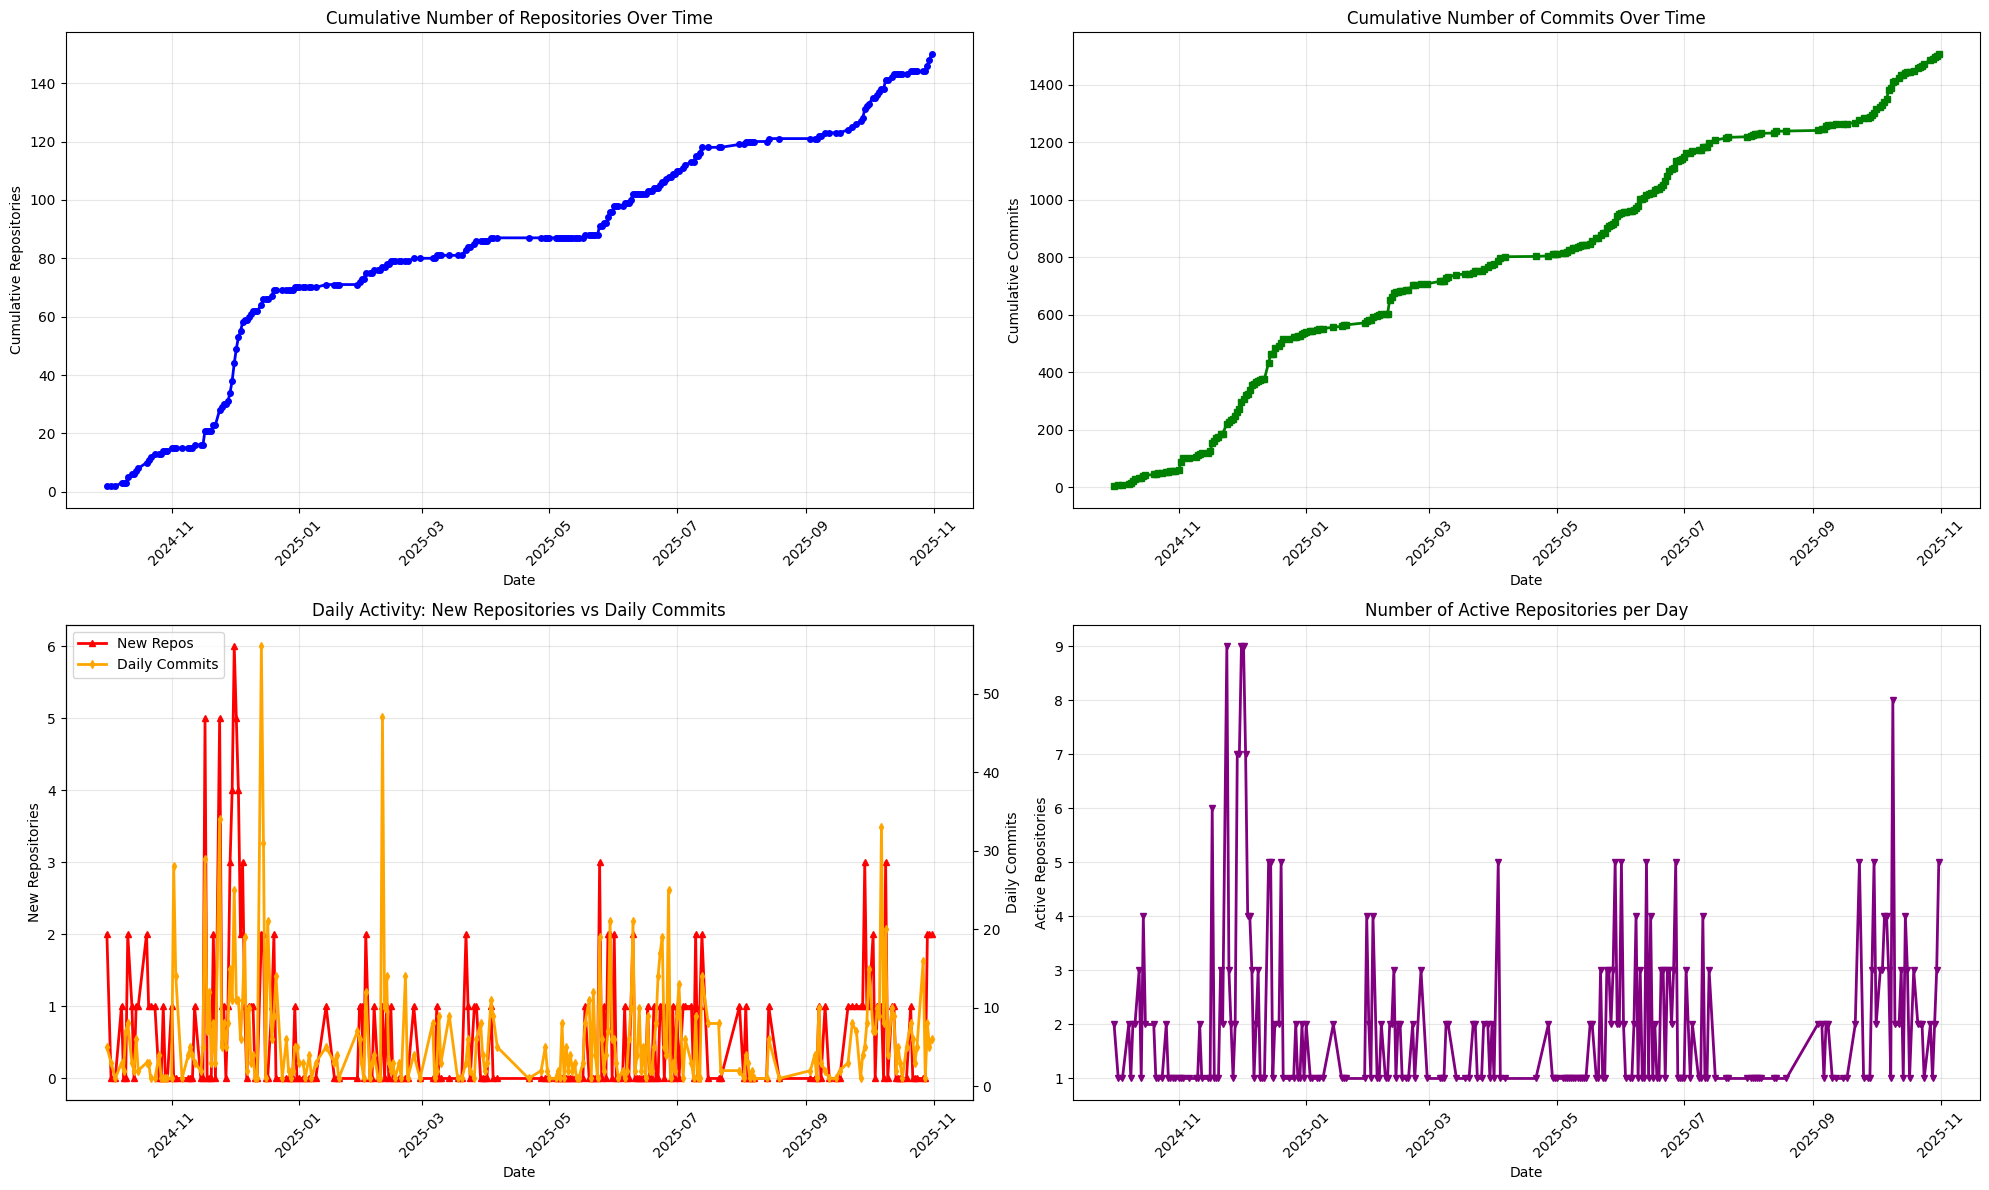


SUMMARY STATISTICS
Total unique repositories: 150
Total commits: 1507
Date range: 2024-10-01 to 2025-10-31
Average commits per day: 6.13
Maximum commits in a day: 56
Days with activity: 246


In [4]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def get_repos(username, token):
    """Fetches all repositories of a given GitHub user."""
    repos = []
    page = 1
    while True:
        url = f"https://api.github.com/users/{username}/repos?page={page}&per_page=100"
        headers = {'Authorization': f'token {token}'}
        response = requests.get(url, headers=headers)
        if response.status_code != 200:
            raise Exception(f"Error fetching repositories: {response.status_code}")
        page_repos = response.json()
        if not page_repos:
            break
        repos.extend(page_repos)
        page += 1
    return repos

def get_commits_for_repos(username, repos, token):
    """Fetches commit data for each repository and accumulates commit counts."""
    all_commits_data = []

    for repo in repos:
        repo_name = repo['name']
        print(f"Fetching commits for repository: {repo_name}")

        commits_url = f"https://api.github.com/repos/{username}/{repo_name}/commits"
        page = 1
        while True:
            headers = {'Authorization': f'token {token}'}
            response = requests.get(commits_url, params={'per_page': 100, 'page': page}, headers=headers)
            if response.status_code != 200:
                print(f"Error fetching commits for {repo_name}, page {page}: {response.status_code}")
                break
            response_data = response.json()
            if len(response_data) == 0:
                break

            for commit in response_data:
                try:
                    commit_date = commit['commit']['author']['date'][:10]  # YYYY-MM-DD
                    all_commits_data.append({
                        'date': commit_date,
                        'repo': repo_name,
                        'commit_sha': commit['sha'][:7]  # Short SHA for reference
                    })
                except KeyError:
                    print(f"Error processing commit data for {repo_name}, commit: {commit}")

            page += 1
            time.sleep(0.1)  # Rate limiting

    return all_commits_data

def calculate_accumulative_metrics(df):
    """Calculate accumulative metrics for repositories and commits."""

    # Sort by date to ensure chronological processing
    df = df.sort_values('date')

    # Initialize tracking dictionaries
    repo_first_seen = {}
    daily_metrics = {}

    # Process each commit to build daily accumulative counts
    for idx, row in df.iterrows():
        date = row['date']
        repo = row['repo']

        # Initialize daily metrics if not exists
        if date not in daily_metrics:
            daily_metrics[date] = {
                'new_repos': set(),
                'total_repos': set(),
                'daily_commits': 0,
                'total_commits': 0
            }

        # Track repository first appearance
        if repo not in repo_first_seen:
            repo_first_seen[repo] = date
            daily_metrics[date]['new_repos'].add(repo)

        # Add repo to total repos for this day
        daily_metrics[date]['total_repos'].add(repo)

        # Count commits
        daily_metrics[date]['daily_commits'] += 1

    # Convert to DataFrame and calculate cumulative metrics
    accumulative_data = []
    cumulative_repos = 0
    cumulative_commits = 0
    all_repos_so_far = set()

    # Process dates in chronological order
    for date in sorted(daily_metrics.keys()):
        daily = daily_metrics[date]

        # Update cumulative repositories
        new_repos_count = len(daily['new_repos'])
        cumulative_repos += new_repos_count
        all_repos_so_far.update(daily['total_repos'])

        # Update cumulative commits
        daily_commits = daily['daily_commits']
        cumulative_commits += daily_commits

        accumulative_data.append({
            'date': date,
            'daily_new_repos': new_repos_count,
            'cumulative_repos': cumulative_repos,
            'daily_commits': daily_commits,
            'cumulative_commits': cumulative_commits,
            'active_repos_today': len(daily['total_repos'])
        })

    return pd.DataFrame(accumulative_data)

def main():
    # Set up the GitHub username and token
    username = "ursa-mikail"
    token = "YOUR_TOKEN_HERE"  # Replace with your GitHub token (ciphered: U2FsdGVkX1+7TtLL8EZXcO+sDvRQ830mnmRH+1bPozCC3DDFIc4hyk/kAlvk6OBrlMhC6s/DVrAJypjnA/6zdQ==)

    # Fetch repositories
    print("Fetching repositories...")
    repos = get_repos(username, token)
    print(f"Found {len(repos)} repositories")

    # Fetch commits for all repositories
    print("Fetching commits...")
    commits_data = get_commits_for_repos(username, repos, token)

    if not commits_data:
        print("No commit data found!")
        return

    # Convert commit data into DataFrame
    df = pd.DataFrame(commits_data)
    print(f"Total commits fetched: {len(df)}")

    # Clean up repository names
    df['repo'] = df['repo'].str.strip().str.lower()
    df['date'] = pd.to_datetime(df['date'])

    # Calculate accumulative metrics
    print("Calculating accumulative metrics...")
    accumulative_df = calculate_accumulative_metrics(df)

    # Save the results to CSV files
    file_raw_commits_csv = './sample_data/git_commits_raw.csv'
    file_accumulative_csv = './sample_data/git_accumulative.csv'

    df.to_csv(file_raw_commits_csv, index=False)
    accumulative_df.to_csv(file_accumulative_csv, index=False)

    print(f"Raw commits CSV file '{file_raw_commits_csv}' created successfully.")
    print(f"Accumulative metrics CSV file '{file_accumulative_csv}' created successfully.")

    # Generate visualizations
    generate_visualizations(accumulative_df, df)

def generate_visualizations(accumulative_df, raw_df):
    """Generate comprehensive visualizations for accumulative metrics."""

    # Convert date to datetime for plotting
    accumulative_df['date'] = pd.to_datetime(accumulative_df['date'])

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

    # Plot 1: Cumulative Repositories Over Time
    ax1.plot(accumulative_df['date'], accumulative_df['cumulative_repos'],
             marker='o', linestyle='-', color='blue', linewidth=2, markersize=4)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative Repositories')
    ax1.set_title('Cumulative Number of Repositories Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    # Plot 2: Cumulative Commits Over Time
    ax2.plot(accumulative_df['date'], accumulative_df['cumulative_commits'],
             marker='s', linestyle='-', color='green', linewidth=2, markersize=4)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Commits')
    ax2.set_title('Cumulative Number of Commits Over Time')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

    # Plot 3: Daily Activity (Dual Y-axis)
    ax3_twin = ax3.twinx()
    line1 = ax3.plot(accumulative_df['date'], accumulative_df['daily_new_repos'],
                     marker='^', linestyle='-', color='red', linewidth=2,
                     markersize=4, label='New Repos')
    line2 = ax3_twin.plot(accumulative_df['date'], accumulative_df['daily_commits'],
                         marker='d', linestyle='-', color='orange', linewidth=2,
                         markersize=4, label='Daily Commits')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('New Repositories')
    ax3_twin.set_ylabel('Daily Commits')
    ax3.set_title('Daily Activity: New Repositories vs Daily Commits')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)

    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax3.legend(lines, labels, loc='upper left')

    # Plot 4: Active Repositories per Day
    ax4.plot(accumulative_df['date'], accumulative_df['active_repos_today'],
             marker='v', linestyle='-', color='purple', linewidth=2, markersize=4)
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Active Repositories')
    ax4.set_title('Number of Active Repositories per Day')
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig('./sample_data/git_accumulative_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary statistics
    print("\n" + "="*50)
    print("SUMMARY STATISTICS")
    print("="*50)
    print(f"Total unique repositories: {raw_df['repo'].nunique()}")
    print(f"Total commits: {len(raw_df)}")
    print(f"Date range: {accumulative_df['date'].min().strftime('%Y-%m-%d')} to {accumulative_df['date'].max().strftime('%Y-%m-%d')}")
    print(f"Average commits per day: {accumulative_df['daily_commits'].mean():.2f}")
    print(f"Maximum commits in a day: {accumulative_df['daily_commits'].max()}")
    print(f"Days with activity: {len(accumulative_df)}")

# Run the main function
if __name__ == "__main__":
    main()

In [7]:
"""
Version for private repos
"""
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
from datetime import datetime
import os

def get_repos_private(username, token):
    """Fetches ALL repositories (including private) for authenticated user."""
    repos = []
    page = 1

    print(f"Fetching repositories for user: {username}")
    print(f"Using token (first 10 chars): {token[:10]}...")

    # Use the authenticated user's endpoint to get ALL repos
    while True:
        url = f"https://api.github.com/user/repos?page={page}&per_page=100&affiliation=owner"
        headers = {
            'Authorization': f'token {token}',
            'Accept': 'application/vnd.github.v3+json',
            'User-Agent': 'Python-Script'
        }

        try:
            response = requests.get(url, headers=headers, timeout=30)
            print(f"Page {page}: Status Code {response.status_code}")

            if response.status_code == 401:
                print("Error: Unauthorized - Check your GitHub token")
                print("Make sure your token has the 'repo' scope enabled")
                break
            elif response.status_code == 403:
                print("Error: Rate limit exceeded or forbidden")
                print(f"Response headers: {dict(response.headers)}")
                break
            elif response.status_code != 200:
                print(f"Error fetching repositories: {response.status_code}")
                print(f"Response: {response.text[:200]}")
                break

            page_repos = response.json()
            print(f"Found {len(page_repos)} repositories on page {page}")

            if not page_repos:
                break

            # Filter repositories for the specific username
            user_repos = [repo for repo in page_repos if repo['owner']['login'].lower() == username.lower()]
            repos.extend(user_repos)
            print(f"  - {len(user_repos)} repositories belong to {username}")

            # Check if we've reached the last page
            if 'next' not in response.links:
                break

            page += 1
            time.sleep(1)  # Rate limiting

        except requests.exceptions.RequestException as e:
            print(f"Request error: {e}")
            break

    return repos

def get_commits_for_repos(username, repos, token):
    """Fetches commit data for each repository (including private)."""
    if not repos:
        print("No repositories to fetch commits from")
        return []

    all_commits_data = []
    repo_count = 0

    for repo in repos:
        repo_name = repo['name']
        repo_private = repo['private']
        repo_count += 1
        print(f"({repo_count}/{len(repos)}) Fetching commits for: {repo_name} {'(private)' if repo_private else ''}")

        commits_url = f"https://api.github.com/repos/{username}/{repo_name}/commits"
        page = 1
        commit_count = 0

        while True:
            headers = {
                'Authorization': f'token {token}',
                'Accept': 'application/vnd.github.v3+json',
                'User-Agent': 'Python-Script'
            }

            try:
                response = requests.get(
                    commits_url,
                    params={'per_page': 100, 'page': page},
                    headers=headers,
                    timeout=30
                )

                if response.status_code == 409:
                    print(f"  Skipping {repo_name} - empty repository")
                    break
                elif response.status_code == 404:
                    print(f"  Cannot access {repo_name} - may not have push access")
                    break
                elif response.status_code == 403:
                    print(f"  Rate limit or access denied for {repo_name}")
                    # Check rate limits
                    rate_limit_url = "https://api.github.com/rate_limit"
                    rate_response = requests.get(rate_limit_url, headers=headers)
                    if rate_response.status_code == 200:
                        rate_data = rate_response.json()
                        core_limits = rate_data['resources']['core']
                        print(f"  Rate limits: {core_limits['remaining']}/{core_limits['limit']} remaining")
                    break
                elif response.status_code != 200:
                    print(f"  Error fetching commits for {repo_name}, page {page}: {response.status_code}")
                    print(f"  Response: {response.text[:100]}")
                    break

                response_data = response.json()

                # Handle case where repository has no commits or cannot access
                if not response_data or len(response_data) == 0:
                    if page == 1:
                        print(f"  No commits found in {repo_name}")
                    break

                page_commit_count = 0
                for commit in response_data:
                    try:
                        # Skip merge commits if desired
                        if commit['commit']['message'].startswith('Merge'):
                            continue

                        commit_date = commit['commit']['author']['date'][:10]  # YYYY-MM-DD
                        all_commits_data.append({
                            'date': commit_date,
                            'repo': repo_name,
                            'private': repo_private,
                            'commit_sha': commit['sha'][:7],
                            'message': commit['commit']['message'][:50]  # First 50 chars
                        })
                        page_commit_count += 1
                        commit_count += 1

                    except (KeyError, TypeError) as e:
                        print(f"  Error processing commit in {repo_name}: {e}")
                        continue

                print(f"  Page {page}: Found {page_commit_count} commits (Total: {commit_count})")

                # Check if we've reached the last page
                if len(response_data) < 100:
                    break

                page += 1
                time.sleep(0.5)  # Rate limiting

            except requests.exceptions.RequestException as e:
                print(f"  Request error for {repo_name}: {e}")
                break

        print(f"  Total commits from {repo_name}: {commit_count}")

    return all_commits_data

def test_authentication(username, token):
    """Test if authentication works and check token scopes."""
    print("Testing authentication...")

    # Test with user endpoint
    test_url = f"https://api.github.com/user"
    headers = {
        'Authorization': f'token {token}',
        'Accept': 'application/vnd.github.v3+json',
        'User-Agent': 'Python-Script'
    }

    try:
        response = requests.get(test_url, headers=headers, timeout=10)
        print(f"Authentication test - Status: {response.status_code}")

        if response.status_code == 200:
            user_data = response.json()
            authenticated_user = user_data.get('login', 'Unknown')
            print(f"✓ Successfully authenticated as: {authenticated_user}")
            print(f"  User: {user_data.get('name', 'Unknown')}")
            print(f"  Total repos: {user_data.get('total_private_repos', 0) + user_data.get('public_repos', 0)}")
            print(f"  Private repos: {user_data.get('total_private_repos', 'N/A')}")
            print(f"  Public repos: {user_data.get('public_repos', 'N/A')}")

            # Check if we're accessing the right user
            if authenticated_user.lower() != username.lower():
                print(f"⚠️  Warning: Authenticated as {authenticated_user} but requesting data for {username}")
                print("  This might cause issues accessing private repositories")

            return True
        else:
            print(f"✗ Authentication failed: {response.status_code}")
            print(f"  Response: {response.text[:200]}")
            return False

    except Exception as e:
        print(f"✗ Authentication test error: {e}")
        return False

def check_token_scopes(token):
    """Check what scopes the token has."""
    print("Checking token scopes...")

    headers = {
        'Authorization': f'token {token}',
        'Accept': 'application/vnd.github.v3+json',
        'User-Agent': 'Python-Script'
    }

    try:
        # Make a request to a scopes endpoint (GitHub doesn't have a direct scopes API)
        # But we can check by making a request to the user repos endpoint
        response = requests.get("https://api.github.com/user/repos", headers=headers)

        if 'X-OAuth-Scopes' in response.headers:
            scopes = response.headers['X-OAuth-Scopes']
            print(f"Token scopes: {scopes}")

            if 'repo' in scopes:
                print("✓ Token has 'repo' scope - can access private repositories")
            else:
                print("✗ Token missing 'repo' scope - cannot access private repositories")
                print("  Generate a new token with 'repo' scope at: https://github.com/settings/tokens")

        return True
    except Exception as e:
        print(f"Error checking token scopes: {e}")
        return False

def calculate_accumulative_metrics(df):
    """Calculate accumulative metrics for repositories and commits."""

    if df.empty:
        print("No data to calculate metrics")
        return pd.DataFrame()

    # Sort by date to ensure chronological processing
    df = df.sort_values('date')

    # Initialize tracking dictionaries
    repo_first_seen = {}
    daily_metrics = {}

    # Process each commit to build daily accumulative counts
    for idx, row in df.iterrows():
        date = row['date']
        repo = row['repo']

        # Initialize daily metrics if not exists
        if date not in daily_metrics:
            daily_metrics[date] = {
                'new_repos': set(),
                'total_repos': set(),
                'daily_commits': 0,
                'total_commits': 0
            }

        # Track repository first appearance
        if repo not in repo_first_seen:
            repo_first_seen[repo] = date
            daily_metrics[date]['new_repos'].add(repo)

        # Add repo to total repos for this day
        daily_metrics[date]['total_repos'].add(repo)

        # Count commits
        daily_metrics[date]['daily_commits'] += 1

    # Convert to DataFrame and calculate cumulative metrics
    accumulative_data = []
    cumulative_repos = 0
    cumulative_commits = 0
    all_repos_so_far = set()

    # Process dates in chronological order
    for date in sorted(daily_metrics.keys()):
        daily = daily_metrics[date]

        # Update cumulative repositories
        new_repos_count = len(daily['new_repos'])
        cumulative_repos += new_repos_count
        all_repos_so_far.update(daily['total_repos'])

        # Update cumulative commits
        daily_commits = daily['daily_commits']
        cumulative_commits += daily_commits

        accumulative_data.append({
            'date': date,
            'daily_new_repos': new_repos_count,
            'cumulative_repos': cumulative_repos,
            'daily_commits': daily_commits,
            'cumulative_commits': cumulative_commits,
            'active_repos_today': len(daily['total_repos'])
        })

    return pd.DataFrame(accumulative_data)

def main():
    # Set up the GitHub username and token
    username = "ursa-mikail"
    token = "YOUR_TOKEN_HERE"  # Replace with your GitHub token (ciphered: U2FsdGVkX1+7TtLL8EZXcO+sDvRQ830mnmRH+1bPozCC3DDFIc4hyk/kAlvk6OBrlMhC6s/DVrAJypjnA/6zdQ==)

    # Replace this with your actual GitHub token
    token = ""  # Your actual token here

    # Test authentication first
    if not test_authentication(username, token):
        print("\n❌ Authentication failed. Please check:")
        print("1. Your GitHub username is correct")
        print("2. Your token is valid and has 'repo' scope")
        print("3. You have an internet connection")
        print("\nGet a token from: https://github.com/settings/tokens")
        return

    # Check token scopes
    check_token_scopes(token)

    # Fetch repositories using the authenticated user endpoint
    print("\n" + "="*50)
    print("Fetching repositories (including private)...")
    repos = get_repos_private(username, token)
    print(f"Found {len(repos)} total repositories")

    # Print repository details
    if repos:
        print("\nRepository details:")
        for repo in repos:
            print(f"  - {repo['name']} ({'private' if repo['private'] else 'public'})")

    if not repos:
        print("No repositories found. Possible reasons:")
        print("1. User has no repositories (public or private)")
        print("2. Token doesn't have 'repo' scope for private access")
        print("3. You're not authenticated as the repository owner")
        return

    # Fetch commits for all repositories
    print("\n" + "="*50)
    print("Fetching commits...")
    commits_data = get_commits_for_repos(username, repos, token)

    if not commits_data:
        print("No commit data found!")
        print("This could be because:")
        print("1. Repositories are empty")
        print("2. All commits are merge commits (filtered out)")
        print("3. API rate limiting")
        print("4. No push access to repositories")
        return

    # Convert commit data into DataFrame
    df = pd.DataFrame(commits_data)
    print(f"\nTotal commits fetched: {len(df)}")
    print(f"Private repositories in data: {df[df['private'] == True]['repo'].nunique()}")

    # Clean up repository names and dates
    df['repo'] = df['repo'].str.strip().str.lower()
    df['date'] = pd.to_datetime(df['date'])

    # Calculate accumulative metrics
    print("\n" + "="*50)
    print("Calculating accumulative metrics...")
    accumulative_df = calculate_accumulative_metrics(df)

    # Create sample_data directory if it doesn't exist
    os.makedirs('./sample_data', exist_ok=True)

    # Save the results to CSV files
    file_raw_commits_csv = './sample_data/git_commits_raw.csv'
    file_accumulative_csv = './sample_data/git_accumulative.csv'

    df.to_csv(file_raw_commits_csv, index=False)
    accumulative_df.to_csv(file_accumulative_csv, index=False)

    print(f"✓ Raw commits CSV file '{file_raw_commits_csv}' created successfully.")
    print(f"✓ Accumulative metrics CSV file '{file_accumulative_csv}' created successfully.")

    # Generate visualizations if we have data
    if not accumulative_df.empty:
        generate_visualizations(accumulative_df, df)
    else:
        print("No data available for visualizations")

def generate_visualizations(accumulative_df, raw_df):
    """Generate comprehensive visualizations for accumulative metrics."""

    # Convert date to datetime for plotting
    accumulative_df['date'] = pd.to_datetime(accumulative_df['date'])

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

    # Plot 1: Cumulative Repositories Over Time
    ax1.plot(accumulative_df['date'], accumulative_df['cumulative_repos'],
             marker='o', linestyle='-', color='blue', linewidth=2, markersize=4)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative Repositories')
    ax1.set_title('Cumulative Number of Repositories Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    # Plot 2: Cumulative Commits Over Time
    ax2.plot(accumulative_df['date'], accumulative_df['cumulative_commits'],
             marker='s', linestyle='-', color='green', linewidth=2, markersize=4)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Commits')
    ax2.set_title('Cumulative Number of Commits Over Time')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

    # Plot 3: Daily Activity (Dual Y-axis)
    ax3_twin = ax3.twinx()
    line1 = ax3.plot(accumulative_df['date'], accumulative_df['daily_new_repos'],
                     marker='^', linestyle='-', color='red', linewidth=2,
                     markersize=4, label='New Repos')
    line2 = ax3_twin.plot(accumulative_df['date'], accumulative_df['daily_commits'],
                         marker='d', linestyle='-', color='orange', linewidth=2,
                         markersize=4, label='Daily Commits')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('New Repositories')
    ax3_twin.set_ylabel('Daily Commits')
    ax3.set_title('Daily Activity: New Repositories vs Daily Commits')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)

    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax3.legend(lines, labels, loc='upper left')

    # Plot 4: Active Repositories per Day
    ax4.plot(accumulative_df['date'], accumulative_df['active_repos_today'],
             marker='v', linestyle='-', color='purple', linewidth=2, markersize=4)
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Active Repositories')
    ax4.set_title('Number of Active Repositories per Day')
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig('./sample_data/git_accumulative_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary statistics
    print("\n" + "="*50)
    print("SUMMARY STATISTICS")
    print("="*50)
    print(f"Total unique repositories: {raw_df['repo'].nunique()}")
    print(f"Total commits: {len(raw_df)}")
    print(f"Date range: {accumulative_df['date'].min().strftime('%Y-%m-%d')} to {accumulative_df['date'].max().strftime('%Y-%m-%d')}")
    print(f"Average commits per day: {accumulative_df['daily_commits'].mean():.2f}")
    print(f"Maximum commits in a day: {accumulative_df['daily_commits'].max()}")
    print(f"Days with activity: {len(accumulative_df)}")

# Run the main function
if __name__ == "__main__":
    main()

Testing authentication...
Authentication test - Status: 401
✗ Authentication failed: 401
  Response: {
  "message": "Bad credentials",
  "documentation_url": "https://docs.github.com/rest",
  "status": "401"
}

❌ Authentication failed. Please check:
1. Your GitHub username is correct
2. Your token is valid and has 'repo' scope
3. You have an internet connection

Get a token from: https://github.com/settings/tokens
